In [3]:
pip install ucimlrepo numpy pandas matplotlib scikit-learn seaborn autograd torch tabulate xgboost mlxtend


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
try:
    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    support2 = fetch_ucirepo(id=880)

    # data (as pandas dataframes)
    X = support2.data.features
    y = support2.data.targets

    # metadata
    print(support2.metadata)

    # variable information
    print(support2.variables)
except ConnectionError as e:
    import pandas as pd
    print("Unable to fetch dataset. Trying to load from local file.")
    support2 = pd.read_csv("data.csv")
    X = support2.iloc[:,:-3]
    y = support2.iloc[:,-3:]

{'uci_id': 880, 'name': 'SUPPORT2', 'repository_url': 'https://archive.ics.uci.edu/dataset/880/support2', 'data_url': 'https://archive.ics.uci.edu/static/public/880/data.csv', 'abstract': "This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994.\nEach row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. \nIt is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier deci

In [5]:
# support2.variables.to_csv("support2_codebook.csv", index=False)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.concat([X,y],axis=1)
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,ph,glucose,bun,urine,adlp,adls,adlsc,death,hospdead,sfdm2
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,...,7.459961,NaN,NaN,NaN,7.0,7.0,7.000000,0,0,NaN
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,...,7.250000,NaN,NaN,NaN,NaN,1.0,1.000000,1,1,<2 mo. follow-up
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,NaN,...,7.459961,NaN,NaN,NaN,1.0,0.0,0.000000,1,0,<2 mo. follow-up
3,42.38498,female,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,1,0,no(M2 and SIP pres)
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,26.0,50127.0,NaN,...,7.509766,NaN,NaN,NaN,NaN,2.0,2.000000,0,0,no(M2 and SIP pres)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,NaN,0.0,52870.0,34329.3125,...,7.459961,188.0,21.0,NaN,NaN,0.0,0.000000,0,0,NaN
9101,55.15399,female,Coma,Coma,1,11.0,NaN,41.0,35377.0,23558.5000,...,7.289062,190.0,49.0,0.0,NaN,0.0,0.000000,0,0,NaN
9102,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,0.0,46564.0,31409.0156,...,7.379883,189.0,60.0,3900.0,NaN,NaN,2.525391,0,0,NaN
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1,13.0,NaN,0.0,58439.0,NaN,...,7.469727,246.0,55.0,NaN,NaN,0.0,0.000000,1,1,<2 mo. follow-up


In [7]:
# missed_target_data = data[data['sfdm2'].isnull()]
# data = data.dropna(subset=['sfdm2'])

In [8]:
from tabulate import tabulate
def dataUnderstanding(data):
  # Number of the rows and columns
  rows, columns = data.shape
  print('-' * 50)
  print(f"Number of Rows:{rows} | Number of Columns:{columns}")
  print('-' * 50)
  print()

  # List of columns
  columns_df = pd.DataFrame(data.columns, columns=["Column Names"])
  print("List of Features in the dataset:")
  print(tabulate(columns_df, headers='keys', tablefmt='psql', showindex=False))
  print('-' * 50)
  print()

  # Print Data type
  print("Summarized basic information:\n")
  data.info()
  print('-' * 50)
  print()

  # printing all the numerical datatype columns
  numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
  print(f"Printing all the numerical columns --> {numerical_columns}")
  print()
  # printing all the object datatype columns
  object_columns = data.select_dtypes(include=['object']).columns.tolist()
  print(f"Printing all the Object columns --> {object_columns}")
  print('-' * 50)
  print()

  # finding the missing values
  print(f"Finding the number of missing values in all the columns -->\n")
  print(data.isna().sum())
  print('-' * 50)


dataUnderstanding(data)

--------------------------------------------------
Number of Rows:9105 | Number of Columns:45
--------------------------------------------------

List of Features in the dataset:
+----------------+
| Column Names   |
|----------------|
| age            |
| sex            |
| dzgroup        |
| dzclass        |
| num.co         |
| edu            |
| income         |
| scoma          |
| charges        |
| totcst         |
| totmcst        |
| avtisst        |
| race           |
| sps            |
| aps            |
| surv2m         |
| surv6m         |
| hday           |
| diabetes       |
| dementia       |
| ca             |
| prg2m          |
| prg6m          |
| dnr            |
| dnrday         |
| meanbp         |
| wblc           |
| hrt            |
| resp           |
| temp           |
| pafi           |
| alb            |
| bili           |
| crea           |
| sod            |
| ph             |
| glucose        |
| bun            |
| urine          |
| adlp           |
| ad

# Data Preprocessing

## Data Cleaning

### Missing Values

In [9]:
missing_value_table = data.isnull().sum()
missing_value_proportion = missing_value_table[missing_value_table>0].sort_values(ascending=False) / len(data)
for i in missing_value_proportion.index:
    print("{}: {:.2f}%".format(i,missing_value_proportion[i]*100), f'dtype={data[i].dtype}')

adlp: 61.95% dtype=float64
urine: 53.40% dtype=float64
glucose: 49.42% dtype=float64
bun: 47.80% dtype=float64
totmcst: 38.17% dtype=float64
alb: 37.03% dtype=float64
income: 32.75% dtype=object
adls: 31.49% dtype=float64
bili: 28.57% dtype=float64
pafi: 25.54% dtype=float64
ph: 25.09% dtype=float64
prg2m: 18.11% dtype=float64
edu: 17.95% dtype=float64
prg6m: 17.94% dtype=float64
sfdm2: 15.38% dtype=object
totcst: 9.75% dtype=float64
wblc: 2.33% dtype=float64
charges: 1.89% dtype=float64
avtisst: 0.90% dtype=float64
crea: 0.74% dtype=float64
race: 0.46% dtype=object
dnrday: 0.33% dtype=float64
dnr: 0.33% dtype=object
scoma: 0.01% dtype=float64
sps: 0.01% dtype=float64
meanbp: 0.01% dtype=float64
aps: 0.01% dtype=float64
surv2m: 0.01% dtype=float64
surv6m: 0.01% dtype=float64
resp: 0.01% dtype=float64
hrt: 0.01% dtype=float64
temp: 0.01% dtype=float64
sod: 0.01% dtype=float64


In [10]:
X_pd = pd.DataFrame(X)
y_pd = pd.DataFrame(y)
X_pd.isnull().sum(), y_pd.isnull().sum()

(age            0
 sex            0
 dzgroup        0
 dzclass        0
 num.co         0
 edu         1634
 income      2982
 scoma          1
 charges      172
 totcst       888
 totmcst     3475
 avtisst       82
 race          42
 sps            1
 aps            1
 surv2m         1
 surv6m         1
 hday           0
 diabetes       0
 dementia       0
 ca             0
 prg2m       1649
 prg6m       1633
 dnr           30
 dnrday        30
 meanbp         1
 wblc         212
 hrt            1
 resp           1
 temp           1
 pafi        2325
 alb         3372
 bili        2601
 crea          67
 sod            1
 ph          2284
 glucose     4500
 bun         4352
 urine       4862
 adlp        5641
 adls        2867
 adlsc          0
 dtype: int64,
 death          0
 hospdead       0
 sfdm2       1400
 dtype: int64)

In [11]:
for i in data.columns:
  print(f'{i}:{data[i].dtype}')

age:float64
sex:object
dzgroup:object
dzclass:object
num.co:int64
edu:float64
income:object
scoma:float64
charges:float64
totcst:float64
totmcst:float64
avtisst:float64
race:object
sps:float64
aps:float64
surv2m:float64
surv6m:float64
hday:int64
diabetes:int64
dementia:int64
ca:object
prg2m:float64
prg6m:float64
dnr:object
dnrday:float64
meanbp:float64
wblc:float64
hrt:float64
resp:float64
temp:float64
pafi:float64
alb:float64
bili:float64
crea:float64
sod:float64
ph:float64
glucose:float64
bun:float64
urine:float64
adlp:float64
adls:float64
adlsc:float64
death:int64
hospdead:int64
sfdm2:object


In [12]:
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

def fill_missing_values_simplified(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing values in a DataFrame using KNNImputer for numerical columns
    and SimpleImputer (most frequent) for categorical columns.

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing missing values.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with missing values filled.
    """
    data_filled = data.copy()
    
    # Identify numerical and categorical columns
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

    # Impute numerical columns with KNNImputer
    if numerical_cols and data_filled[numerical_cols].isnull().sum().sum() > 0:
        knn_imputer = KNNImputer(n_neighbors=13,weights='distance')
        data_filled[numerical_cols] = knn_imputer.fit_transform(data_filled[numerical_cols])

    # Impute categorical columns with the most frequent value
    if categorical_cols and data_filled[categorical_cols].isnull().sum().sum() > 0:
        simple_imputer = SimpleImputer(strategy='most_frequent')
        data_filled[categorical_cols] = simple_imputer.fit_transform(data_filled[categorical_cols])

    return data_filled

# Create a copy to avoid modifying the original data in place
data_filled = data.copy()

# Loop through columns with missing values and apply the simplified filling logic
for col in missing_value_proportion.index:
    # Add a missing value indicator column before filling
    data_filled['missing_' + col] = data_filled[col].isnull().astype(float)
    if missing_value_proportion[col] > 0.35:
        print(f"Column '{col}' has more than 35% missing values, skipping imputation.")
        data_filled.drop(columns=[col], inplace=True)

# Apply the simplified imputation to the whole dataframe
data = fill_missing_values_simplified(data_filled)


Column 'adlp' has more than 35% missing values, skipping imputation.
Column 'urine' has more than 35% missing values, skipping imputation.
Column 'glucose' has more than 35% missing values, skipping imputation.
Column 'bun' has more than 35% missing values, skipping imputation.
Column 'totmcst' has more than 35% missing values, skipping imputation.
Column 'alb' has more than 35% missing values, skipping imputation.


In [13]:
data.isnull().sum()

age               0
sex               0
dzgroup           0
dzclass           0
num.co            0
                 ..
missing_surv6m    0
missing_resp      0
missing_hrt       0
missing_temp      0
missing_sod       0
Length: 72, dtype: int64

In [14]:
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,missing_scoma,missing_sps,missing_meanbp,missing_aps,missing_surv2m,missing_surv6m,missing_resp,missing_hrt,missing_temp,missing_sod
0,62.84998,male,Lung Cancer,Cancer,0.0,11.000000,$11-$25k,0.0,9715.0,11718.099513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,$11-$25k,44.0,34496.0,92090.054660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,17761.684038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,5142.416420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.094718,under $11k,26.0,50127.0,23075.464461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,8.000000,under $11k,0.0,52870.0,34329.312500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9101,55.15399,female,Coma,Coma,1.0,11.000000,under $11k,41.0,35377.0,23558.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9102,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,11.485002,under $11k,0.0,46564.0,31409.015600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,24255.341140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Outlier Detection

In [15]:
def outlier_detection(data):
    """
    Detect outliers for numerical and categorical features.
    Returns a DataFrame with outlier flags (1=outlier, 0=normal) for each method.
    """
    results = data.copy()
    outlier_flags = pd.DataFrame(index=results.index)

    # Numerical: IQR method (threshold=2.5, typical for moderate outlier frequency)
    num_cols = results.select_dtypes(include=["number"]).columns
    # Exclude columns that start with 'missing_'
    num_cols = [col for col in num_cols if not col.startswith('missing_')]
    def iqr_detector(col, threshold=2.5):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return ((col < lower_bound) | (col > upper_bound)).astype(int)
    for col in num_cols:
        outlier_flags[f'iqr_{col}'] = iqr_detector(results[col])

    # Categorical: rare category (threshold=0.005, i.e., <.5% frequency)
    cat_cols = results.select_dtypes(include=["object", "category"]).columns
    def category_outlier_detector(col, threshold=0.005):
        freq = col.value_counts(normalize=True)
        rare_categories = freq[freq < threshold].index
        return col.isin(rare_categories).astype(int)
    for col in cat_cols:
        outlier_flags[f'cat_outlier_{col}'] = category_outlier_detector(results[col])

    return outlier_flags

In [16]:
demo = outlier_detection(data.copy())
demo.describe()

,iqr_age,iqr_num.co,iqr_edu,iqr_scoma,iqr_charges,iqr_totcst,iqr_avtisst,iqr_sps,iqr_aps,iqr_surv2m,...,iqr_death,iqr_hospdead,cat_outlier_sex,cat_outlier_dzgroup,cat_outlier_dzclass,cat_outlier_income,cat_outlier_race,cat_outlier_ca,cat_outlier_dnr,cat_outlier_sfdm2
count,9105.0,9105.00000,9105.000000,9105.000000,9105.000000,9105.000000,9105.00000,9105.000000,9105.000000,9105.0,...,9105.0,9105.0,9105.0,9105.0,9105.0,9105.0,9105.0,9105.0,9105.0,9105.000000
mean,0.0,0.00011,0.030423,0.166502,0.062493,0.048984,0.00011,0.010544,0.001867,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004503
std,0.0,0.01048,0.171757,0.372551,0.242062,0.215847,0.01048,0.102145,0.043172,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066957
min,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,0.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [17]:
count = 0
for row in demo.index:
    if demo.loc[row].sum() > 1:
        # print(f"Row {row} is an outlier in the following methods: {demo.loc[row][demo.loc[row] == 1].index.tolist()}")
        pass
    else:
        count += 1
count

7012

In [18]:
# delete outliers
def remove_outliers(data):
    """
    Remove outliers from the DataFrame.
    Returns a DataFrame with outliers removed.
    """
    crit = outlier_detection(data)
    for row in crit.index:
        if crit.loc[row].sum() > 1:
            data = data.drop(row)
    return data

data_no_outliers = remove_outliers(data.copy())

In [19]:
# recode the index
data_no_outliers.reset_index(drop=True, inplace=True)
data_no_outliers

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,missing_scoma,missing_sps,missing_meanbp,missing_aps,missing_surv2m,missing_surv6m,missing_resp,missing_hrt,missing_temp,missing_sod
0,62.84998,male,Lung Cancer,Cancer,0.0,11.000000,$11-$25k,0.0,9715.0,11718.099513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,17761.684038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,5142.416420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.094718,under $11k,26.0,50127.0,23075.464461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,62.37097,male,CHF,COPD/CHF/Cirrhosis,1.0,14.000000,$25-$50k,0.0,30460.0,16718.176856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,2758.0,1847.376000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7008,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,8.000000,under $11k,0.0,52870.0,34329.312500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7009,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,11.485002,under $11k,0.0,46564.0,31409.015600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7010,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,24255.341140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Engineering

### Feature Addition and Classification

In [20]:
data = data_no_outliers
data["Age_Class"] = pd.cut(data["age"], bins=[0, 40, 65, 79, 130], labels=["Young Adult","Adult", "Senior", "Elderly"])
data["Age_Class"].value_counts()

Age_Class
Adult          2908
Senior         2543
Elderly         932
Young Adult     629
Name: count, dtype: int64

In [21]:
data['Risk'] = data['surv2m'] * data['surv2m'] / (data['surv6m']+1e-3)
data['phy_Risk'] = data['prg2m'] * data['prg2m'] / (data['prg6m']+1e-3)
data['short_term_diff'] = data['surv2m'] / (data['prg2m']+1e-3)
data['long_term_diff'] = data['surv6m'] / (data['prg6m']+1e-3)
# sigmoid scaling, change into [0,1] range and indicate a probability of shouldering a risk for month, which in common sense, is related to sfdm2 or death
data['Risk'] = 1 / (1 + np.exp(-data['Risk']))
data['Risk'].describe()

count    7012.000000
mean        0.706818
std         0.054371
min         0.500000
25%         0.688661
50%         0.715982
75%         0.725479
max         0.930901
Name: Risk, dtype: float64

In [22]:
# costs are often right skewed, so we can use log transformation
data['charges_log'] = np.log(data['charges'] + 1e-3)  # Adding a small constant to avoid log(0)

data['totcst_log'] = np.log(data['totcst'] + 1e-3)  # Adding a small constant to avoid log(0)
data['totcst_log'] = 5*(data['totcst_log']-min(data['totcst_log'])) # shift the minimum value to 0 and increase sparseness

data[['charges_log', 'totcst_log']].describe()

,charges_log,totcst_log
count,7012.000000,7012.000000
mean,9.878346,81.352174
std,1.092380,6.326851
min,7.063905,0.000000
25%,9.025395,77.541699
50%,9.861311,81.526982
75%,10.703537,85.421912
max,12.813945,95.505632


In [23]:
# Vital Signs
# These are often important indicators of health status and can be used to predict outcomes.
data['low_BP'] = data['meanbp'] <= 65
data['high_HR'] = data['hrt'] >= 100
data['high_resp'] = data['resp'] >= 30
data['high_temp'] = data['temp'] >= 38.0
data['low_temp'] = data['temp'] <= 36.0
data[['low_BP', 'high_HR', 'high_resp', 'high_temp', 'low_temp']].describe()

,low_BP,high_HR,high_resp,high_temp,low_temp
count,7012,7012,7012,7012,7012
unique,2,2,2,2,2
top,False,False,False,False,False
freq,5224,3582,5545,5074,5627


In [24]:
# pafi is a measure of the severity of illness, often used in critical care settings.
data['ARDS_severity'] = data['pafi'].apply(lambda x: 'Normal' if x >=300 else ('Mild' if x >= 200 else ('Moderate' if x >= 100 else 'Severe')))
data['ARDS_severity'].value_counts()

ARDS_severity
Mild        3363
Moderate    1688
Normal      1658
Severe       303
Name: count, dtype: int64

In [25]:
# arterial ph
data['acidosis'] = data['ph'] < 7.35
data['alkalosis'] = data['ph'] > 7.45
data[['acidosis', 'alkalosis']].describe()

,acidosis,alkalosis
count,7012,7012
unique,2,2
top,False,False
freq,6228,5268


In [26]:
# Bilirubin is a measure of liver function, often used in critical care settings.
data['bili_high'] = data['bili'] > 2.0
data[['bili_high']].describe()

,bili_high
count,7012
unique,2
top,False
freq,5463


In [27]:
# Creatinine is a measure of kidney function, often used in critical care settings.
data['creatinine_high'] = data['crea'] > 2
data[['creatinine_high']].describe()

,creatinine_high
count,7012
unique,2
top,False
freq,5857


In [28]:
# adl scores
# 1. disability level
data['disability_level'] = data['adlsc'] <4
data[['disability_level']].describe()

,disability_level
count,7012
unique,2
top,True
freq,5952


In [29]:
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,high_HR,high_resp,high_temp,low_temp,ARDS_severity,acidosis,alkalosis,bili_high,creatinine_high,disability_level
0,62.84998,male,Lung Cancer,Cancer,0.0,11.000000,$11-$25k,0.0,9715.0,11718.099513,...,False,False,False,True,Normal,False,True,False,False,False
1,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,17761.684038,...,False,False,False,False,Mild,False,True,True,False,True
2,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,5142.416420,...,False,True,False,True,Mild,False,False,False,False,True
3,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.094718,under $11k,26.0,50127.0,23075.464461,...,True,False,False,False,Moderate,False,True,True,False,True
4,62.37097,male,CHF,COPD/CHF/Cirrhosis,1.0,14.000000,$25-$50k,0.0,30460.0,16718.176856,...,True,False,False,False,Normal,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,2758.0,1847.376000,...,True,False,False,False,Moderate,False,True,False,False,True
7008,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,8.000000,under $11k,0.0,52870.0,34329.312500,...,True,False,False,True,Mild,False,True,False,False,True
7009,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,11.485002,under $11k,0.0,46564.0,31409.015600,...,False,False,False,False,Moderate,False,False,False,True,True
7010,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,24255.341140,...,True,False,False,False,Normal,False,True,False,True,True


### Feature selection

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import numpy as np
data_no_low_importance = data.copy()
# Prepare the data
# Drop target columns and select only numeric features for X
X_num_df = data_no_low_importance.drop(columns=['death', 'sfdm2', 'hospdead']).select_dtypes(include=np.number)
X_cat_df = data_no_low_importance.drop(columns=['death', 'sfdm2', 'hospdead']).select_dtypes(include=['object', 'category'])

# Encode categorical features
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_cat_encoded = oe.fit_transform(X_cat_df)

# Scale numerical features
ss = StandardScaler()
X_num_scaled = ss.fit_transform(X_num_df)

# Combine numerical and categorical features
X_processed = np.concatenate([X_num_scaled, X_cat_encoded], axis=1)
all_features = X_num_df.columns.tolist() + X_cat_df.columns.tolist()

# Encode the target variable y
y = data_no_low_importance['death']
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# Use a solver that supports 'l1' penalty
selector = SelectFromModel(LogisticRegression(penalty="l1", C=.1, solver='liblinear', random_state=42))
X_new = selector.fit_transform(X_processed, y_encoded)

# To see the selected features
selected_features = np.array(all_features)[selector.get_support()]
print("Selected features:", selected_features.tolist())
print(X_processed.shape, "->", X_new.shape)

Selected features: ['age', 'num.co', 'scoma', 'totcst', 'avtisst', 'sps', 'aps', 'surv6m', 'hday', 'diabetes', 'prg2m', 'prg6m', 'meanbp', 'resp', 'temp', 'pafi', 'bili', 'crea', 'sod', 'adls', 'adlsc', 'missing_adlp', 'missing_urine', 'missing_bun', 'missing_totmcst', 'missing_alb', 'missing_income', 'missing_adls', 'missing_bili', 'missing_ph', 'missing_edu', 'missing_prg6m', 'missing_sfdm2', 'missing_totcst', 'missing_wblc', 'missing_avtisst', 'missing_race', 'missing_scoma', 'missing_aps', 'missing_surv2m', 'missing_surv6m', 'Risk', 'short_term_diff', 'charges_log', 'totcst_log', 'sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr', 'Age_Class', 'ARDS_severity']
(7012, 77) -> (7012, 54)


In [53]:
# gradient boosting feature importance
from sklearn.ensemble import GradientBoostingClassifier

X_new_df = pd.DataFrame(X_new, columns=selected_features)
y = data_no_low_importance['death']
selector_gb = SelectFromModel(GradientBoostingClassifier(max_depth=6, n_estimators=100, random_state=42))
X_new_gb = selector_gb.fit_transform(X_processed, y_encoded)

# To see the selected features
selected_features_gb = np.array(all_features)[selector_gb.get_support()]
print("Selected features (Gradient Boosting):", selected_features_gb.tolist())
print(X_processed.shape, "->", X_new_gb.shape)

Selected features (Gradient Boosting): ['age', 'num.co', 'edu', 'avtisst', 'sps', 'aps', 'surv6m', 'prg6m', 'dnrday', 'meanbp', 'wblc', 'hrt', 'temp', 'pafi', 'crea', 'ph', 'adlsc', 'missing_bun', 'Risk', 'phy_Risk', 'long_term_diff', 'charges_log', 'dzgroup', 'ca', 'dnr']
(7012, 77) -> (7012, 25)


In [32]:
final_features = np.unique(np.concatenate([selected_features, selected_features_gb]))
print("Final selected features:", final_features.tolist())
target_cols = ['death', 'sfdm2', 'hospdead']
# Ensure target columns are not in the final features list
final_features = [f for f in final_features if f not in target_cols]
data_no_low_importance = data_no_low_importance[final_features + target_cols]

Final selected features: ['Risk', 'adls', 'adlsc', 'age', 'aps', 'avtisst', 'ca', 'charges_log', 'crea', 'dnr', 'dnrday', 'dzgroup', 'edu', 'hrt', 'income', 'long_term_diff', 'meanbp', 'missing_bun', 'missing_ph', 'missing_prg6m', 'missing_sfdm2', 'num.co', 'pafi', 'ph', 'phy_Risk', 'prg6m', 'race', 'sex', 'sps', 'surv6m', 'temp', 'wblc']


In [54]:
data_no_low_importance

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,high_HR,high_resp,high_temp,low_temp,ARDS_severity,acidosis,alkalosis,bili_high,creatinine_high,disability_level
0,62.84998,male,Lung Cancer,Cancer,0.0,11.000000,$11-$25k,0.0,9715.0,11718.099513,...,False,False,False,True,Normal,False,True,False,False,False
1,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,41094.0,17761.684038,...,False,False,False,False,Mild,False,True,True,False,True
2,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,under $11k,0.0,3075.0,5142.416420,...,False,True,False,True,Mild,False,False,False,False,True
3,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.094718,under $11k,26.0,50127.0,23075.464461,...,True,False,False,False,Moderate,False,True,True,False,True
4,62.37097,male,CHF,COPD/CHF/Cirrhosis,1.0,14.000000,$25-$50k,0.0,30460.0,16718.176856,...,True,False,False,False,Normal,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,under $11k,0.0,2758.0,1847.376000,...,True,False,False,False,Moderate,False,True,False,False,True
7008,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,8.000000,under $11k,0.0,52870.0,34329.312500,...,True,False,False,True,Mild,False,True,False,False,True
7009,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,11.485002,under $11k,0.0,46564.0,31409.015600,...,False,False,False,False,Moderate,False,False,False,True,True
7010,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,under $11k,0.0,58439.0,24255.341140,...,True,False,False,False,Normal,False,True,False,True,True


In [55]:
cat_cols = data_no_low_importance.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr', 'sfdm2',
       'Age_Class', 'ARDS_severity'],
      dtype='object')

In [56]:
# # delete columns with low feature importance
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# def delete_low_importance_features(data, target_cols, threshold=0.01):
#     """
#     Delete columns with low feature importance based on Random Forest Classifier.
    
#     Parameters:
#     -----------
#     data : pd.DataFrame
#         The input DataFrame containing features and target.
#     target_cols : list
#         The names of the target columns.
#     threshold : float
#         The minimum feature importance value to retain a feature.
        
#     Returns:
#     --------
#     pd.DataFrame
#         The DataFrame with low importance features removed.
#     """
#     oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     X = data.drop(columns=target_cols)
#     y = data[target_cols[0]]  # Use the first target column for feature importance

#     # Encode categorical columns
#     X_encoded = X.copy()
#     cat_cols = X_encoded.select_dtypes(include=['object', 'category']).columns
#     if len(cat_cols) > 0:
#         X_encoded[cat_cols] = oe.fit_transform(X_encoded[cat_cols])

#     # Replace inf/-inf with np.nan, then fill np.nan with column median
#     X_encoded = X_encoded.replace([np.inf, -np.inf], np.nan)
#     X_encoded = X_encoded.fillna(X_encoded.median(numeric_only=True))

#     # Fit Random Forest Classifier
#     model = RandomForestClassifier(n_estimators=500,criterion='entropy',random_state=42)
#     model.fit(X_encoded, y)

#     # Get feature importances
#     importances = model.feature_importances_

#     # Select features above the threshold
#     selected_features = X_encoded.columns[importances > threshold]
    
#     return data[selected_features.tolist() + target_cols], model.feature_importances_
# # Only drop columns that exist in the DataFrame
# target_cols = [col for col in ['death', 'sfdm2', 'hospdead'] if col in data_no_outliers.columns]
# data_no_low_importance, importance = delete_low_importance_features(data_no_outliers, target_cols=target_cols, threshold=0.0025)

# # plot feature importances for selected features only
# selected_features = data_no_low_importance.drop(columns=['death']).columns

# # Only drop columns that exist in the DataFrame for original_features
# original_features = data_no_outliers.drop(columns=target_cols).columns

# # Get importances for selected_features by matching their positions in original_features
# selected_importances = [importance[original_features.get_loc(col)] for col in selected_features if col in original_features]

# # Ensure selected_features and selected_importances have the same length
# selected_features_plot = [col for col in selected_features if col in original_features]

# plt.figure(figsize=(10, 6))
# plt.barh(selected_features_plot, selected_importances)
# plt.xlabel('Feature Importance')
# plt.title('Feature Importances after Removing Low Importance Features')
# plt.show()
# print(f"Number of features after removing low importance features: {len(selected_features_plot)}")

In [57]:
# dataUnderstanding(data_no_low_importance)

In [58]:
# Replace inf/-inf with np.nan before imputation
data_no_low_importance = data_no_low_importance.replace([np.inf, -np.inf], [1e6,1e-6])
data_no_low_importance = fill_missing_values_simplified(data_no_low_importance)
data_no_low_importance.isnull().sum()

age                 0
sex                 0
dzgroup             0
dzclass             0
num.co              0
                   ..
acidosis            0
alkalosis           0
bili_high           0
creatinine_high     0
disability_level    0
Length: 90, dtype: int64

In [59]:
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder
NominalEncoder_list = ['dzgroup', 'dzclass','ca', 'dnr','sex','race','Age_Class']
map_information = {'nominal':{},'ordinal':{}}
# check the number of unique values in each categorical column
for col in cat_cols:
    print(f"Number of unique values in {col}: {data_no_low_importance[col].nunique()}")

Number of unique values in sex: 2
Number of unique values in dzgroup: 8
Number of unique values in dzclass: 4
Number of unique values in income: 4
Number of unique values in race: 5
Number of unique values in ca: 3
Number of unique values in dnr: 3
Number of unique values in sfdm2: 5
Number of unique values in Age_Class: 4
Number of unique values in ARDS_severity: 4


In [60]:
# Ensure data_no_low_importance is defined
if 'data_no_low_importance' not in globals():
    # Only drop columns that exist in the DataFrame
    target_cols = [col for col in ['death', 'sfdm2', 'hospdead'] if col in data_no_outliers.columns]
    data_no_low_importance, importance = delete_low_importance_features(data_no_outliers, target_cols=target_cols, threshold=0.005)

# encode nominal encoder list as onehot encoder
for col in NominalEncoder_list:
    if col in data_no_low_importance.columns:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_col = ohe.fit_transform(data_no_low_importance[[col]])
        encoded_col_df = pd.DataFrame(encoded_col, columns=[f"{col}_{i}" for i in range(encoded_col.shape[1])], index=data_no_low_importance.index)
        data_no_low_importance = pd.concat([data_no_low_importance, encoded_col_df], axis=1)
        # data_no_low_importance.drop(columns=[col], inplace=True)
        # record the mapping information
        map_information['nominal'][col] = ohe.categories_[0].tolist()
map_information

{'nominal': {'dzgroup': ['ARF/MOSF w/Sepsis',
   'CHF',
   'COPD',
   'Cirrhosis',
   'Colon Cancer',
   'Coma',
   'Lung Cancer',
   'MOSF w/Malig'],
  'dzclass': ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma'],
  'ca': ['metastatic', 'no', 'yes'],
  'dnr': ['dnr after sadm', 'dnr before sadm', 'no dnr'],
  'sex': ['female', 'male'],
  'race': ['asian', 'black', 'hispanic', 'other', 'white'],
  'Age_Class': ['Adult', 'Elderly', 'Senior', 'Young Adult']},
 'ordinal': {}}

In [61]:
# encode ordinal encoder list and numeric columns
for col in cat_cols:
    # Skip columns that have been one-hot encoded and dropped, or are not present
    if col in NominalEncoder_list or col not in data_no_low_importance.columns:
        continue
    if data_no_low_importance[col].nunique() <= 30 and col!="scoma":  # Ordinal encoding for categorical columns (all with <= 30 unique values after manual check)
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        data_no_low_importance[col] = oe.fit_transform(data_no_low_importance[[col]])
        # record the mapping information as a dictionary: number value -> original value
        map_information['ordinal'][col] = {i: v for i, v in enumerate(oe.categories_[0])}
    else:
        data_no_low_importance[col] = data_no_low_importance[col].astype(float)  # Convert to float since mostly stated as float in the codebook
print(map_information)
# Only show columns that still exist
remaining_cat_cols = [col for col in cat_cols if col in data_no_low_importance.columns]
data_no_low_importance[remaining_cat_cols]

{'nominal': {'dzgroup': ['ARF/MOSF w/Sepsis', 'CHF', 'COPD', 'Cirrhosis', 'Colon Cancer', 'Coma', 'Lung Cancer', 'MOSF w/Malig'], 'dzclass': ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma'], 'ca': ['metastatic', 'no', 'yes'], 'dnr': ['dnr after sadm', 'dnr before sadm', 'no dnr'], 'sex': ['female', 'male'], 'race': ['asian', 'black', 'hispanic', 'other', 'white'], 'Age_Class': ['Adult', 'Elderly', 'Senior', 'Young Adult']}, 'ordinal': {'income': {0: '$11-$25k', 1: '$25-$50k', 2: '>$50k', 3: 'under $11k'}, 'sfdm2': {0: '<2 mo. follow-up', 1: 'Coma or Intub', 2: 'SIP>=30', 3: 'adl>=4 (>=5 if sur)', 4: 'no(M2 and SIP pres)'}, 'ARDS_severity': {0: 'Mild', 1: 'Moderate', 2: 'Normal', 3: 'Severe'}}}


,sex,dzgroup,dzclass,income,race,ca,dnr,sfdm2,Age_Class,ARDS_severity
0,male,Lung Cancer,Cancer,0.0,other,metastatic,no dnr,0.0,Adult,2.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,3.0,white,no,no dnr,0.0,Adult,0.0
2,female,Lung Cancer,Cancer,3.0,white,metastatic,no dnr,4.0,Adult,0.0
3,female,ARF/MOSF w/Sepsis,ARF/MOSF,3.0,white,no,no dnr,4.0,Elderly,1.0
4,male,CHF,COPD/CHF/Cirrhosis,1.0,white,no,no dnr,4.0,Adult,2.0
...,...,...,...,...,...,...,...,...,...,...
7007,female,COPD,COPD/CHF/Cirrhosis,3.0,white,yes,dnr after sadm,4.0,Senior,1.0
7008,male,ARF/MOSF w/Sepsis,ARF/MOSF,3.0,white,no,no dnr,0.0,Senior,0.0
7009,male,ARF/MOSF w/Sepsis,ARF/MOSF,3.0,white,no,no dnr,0.0,Senior,1.0
7010,male,MOSF w/Malig,ARF/MOSF,3.0,white,yes,dnr after sadm,0.0,Adult,2.0


In [62]:
data_no_low_importance.isnull().sum()

age            0
sex            0
dzgroup        0
dzclass        0
num.co         0
              ..
race_4         0
Age_Class_0    0
Age_Class_1    0
Age_Class_2    0
Age_Class_3    0
Length: 119, dtype: int64

In [63]:
data_no_low_importance

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,sex_1,race_0,race_1,race_2,race_3,race_4,Age_Class_0,Age_Class_1,Age_Class_2,Age_Class_3
0,62.84998,male,Lung Cancer,Cancer,0.0,11.000000,0.0,0.0,9715.0,11718.099513,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2.0,12.000000,3.0,0.0,41094.0,17761.684038,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,42.38498,female,Lung Cancer,Cancer,2.0,11.000000,3.0,0.0,3075.0,5142.416420,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,10.094718,3.0,26.0,50127.0,23075.464461,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,62.37097,male,CHF,COPD/CHF/Cirrhosis,1.0,14.000000,1.0,0.0,30460.0,16718.176856,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,68.61597,female,COPD,COPD/CHF/Cirrhosis,2.0,12.000000,3.0,0.0,2758.0,1847.376000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7008,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,8.000000,3.0,0.0,52870.0,34329.312500,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7009,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1.0,11.485002,3.0,0.0,46564.0,31409.015600,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7010,47.01999,male,MOSF w/Malig,ARF/MOSF,1.0,13.000000,3.0,0.0,58439.0,24255.341140,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Data Visualization

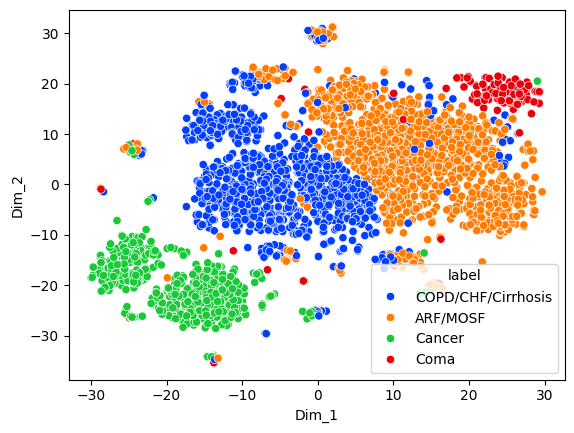

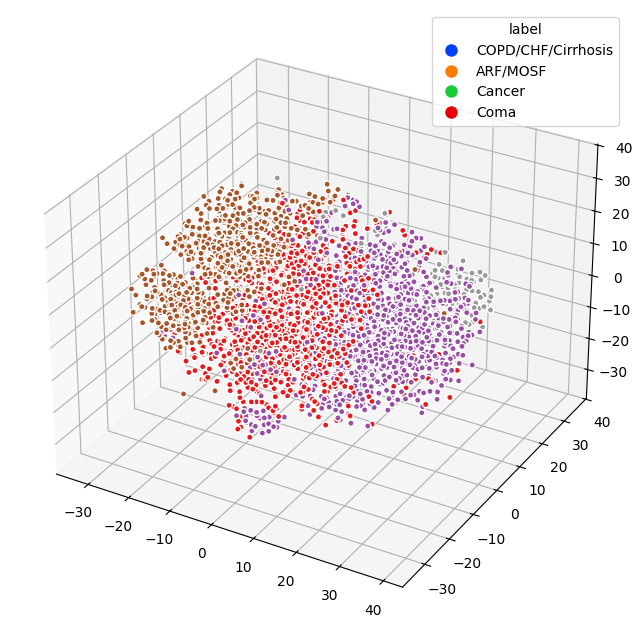

In [66]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
df = data_no_low_importance
def t_sne_plotting(col):
    target_col = df[col]
    
    # Drop target columns and one-hot encoded columns related to the label
    cols_to_drop = target_cols + [c for c in df.columns if c.startswith(col + '_')]
    reduced_df = df.drop(columns=cols_to_drop)

    # 2D t-SNE plot
    np.random.seed(3407)
    indexes = np.random.choice(reduced_df.index, size=3000, replace=False)
    data_1000 = reduced_df.loc[indexes]
    labels_1000 = target_col.loc[indexes]
    
    scaler = StandardScaler()
    # Select only numeric columns for scaling
    numeric_cols = data_1000.select_dtypes(include=np.number).columns
    scaled_data = scaler.fit_transform(data_1000[numeric_cols])
    
    tsne = TSNE(n_components=2, perplexity=100, random_state=3407, max_iter=1000)
    tsne_result = tsne.fit_transform(scaled_data)
    tsne_df = pd.DataFrame(data=tsne_result, columns=["Dim_1", "Dim_2"])

    # Handle label mapping
    if col in map_information['nominal']:
        # For one-hot encoded nominal features, the labels are the original strings
        labels = labels_1000.values
    elif col in map_information['ordinal']:
        # For ordinal features, map encoded values back to original labels
        label_map = map_information['ordinal'].get(col, {})
        labels = [label_map.get(int(l), "unknown") for l in labels_1000.values]
    else:
        # For binary features
        label_map = {1: 'True_'+col, 0: 'False_'+col}
        labels = [label_map.get(l, "unknown") for l in labels_1000.values]
        
    tsne_df["label"] = labels

    sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
                hue='label', palette="bright")
    plt.show()
    
    # 3D t-SNE plot
    tsne_3D = TSNE(n_components=3, perplexity=100, random_state=3407, max_iter=1000)
    tsne_result_3D = tsne_3D.fit_transform(scaled_data)
    tsne_df_3D = pd.DataFrame(data=tsne_result_3D, columns=["Dim_1", "Dim_2", "Dim_3"])
    tsne_df_3D["label"] = labels

    # Map string labels to integers for coloring
    unique_labels = tsne_df_3D["label"].unique()
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    tsne_df_3D["label_int"] = tsne_df_3D["label"].map(label_to_int)

    from matplotlib.colors import ListedColormap, BoundaryNorm

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a ListedColormap for consistent color mapping
    cmap = plt.get_cmap("Set1", len(unique_labels))
    norm = BoundaryNorm(range(len(unique_labels) + 1), cmap.N)

    scatter = ax.scatter(
        tsne_df_3D["Dim_1"], tsne_df_3D["Dim_2"], tsne_df_3D["Dim_3"],
        c=tsne_df_3D["label_int"], cmap=cmap, norm=norm, alpha=1, edgecolors='white'
    )

    # Create legend with matching colors
    # Create a ListedColormap from a seaborn palette for brighter colors
    bright_palette = sns.color_palette("bright", len(unique_labels))
    cmap = ListedColormap(bright_palette)
    
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=label,
                   markerfacecolor=cmap(label_to_int[label]), markersize=10) for label in unique_labels
    ]
    ax.legend(handles=handles, title="label")
    plt.show()

t_sne_plotting('dzclass')

In [70]:
# Clustering Analysis
df = data_no_low_importance
df.to_csv("preprocessed_data.csv",index=False)

# Prediction: Training and Testing

# Evaluation and Choice of Prediction Model

# Open-Ended Exploration